In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib widget


## Генерация входа

In [2]:

pattern_10x10 = np.array([
    [0,0,0,0,2,2,0,0,0,0],
    [0,0,2,2,2,2,2,2,0,0],
    [0,2,0,0,2,2,0,0,2,0],
    [0,2,0,2,2,2,2,0,2,0],
    [2,2,2,2,2,2,2,2,2,2],
    [2,2,2,2,2,2,2,2,2,2],
    [0,2,0,2,2,2,2,0,2,0],
    [0,2,0,0,2,2,0,0,2,0],
    [0,0,2,2,2,2,2,2,0,0],
    [0,0,0,0,2,2,0,0,0,0],
], dtype=float)

pattern_vector = pattern_10x10.flatten()  # длина 100

In [3]:
def generate_Vg(mode):
    if mode == "pattern":
        return pattern_vector.copy()
    else:
        return np.random.choice([0.0, 2.0], size=100, p=[0.85, 0.15])


In [4]:
Vg = generate_Vg("pattern")   # или "noise"
print(Vg)
print(Vg.shape)

[0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 0. 0. 0. 2. 0. 0.
 2. 2. 0. 0. 2. 0. 0. 2. 0. 2. 2. 2. 2. 0. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 0. 2. 2. 2. 2. 0. 2. 0. 0. 2.
 0. 0. 2. 2. 0. 0. 2. 0. 0. 0. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 2. 2.
 0. 0. 0. 0.]
(100,)


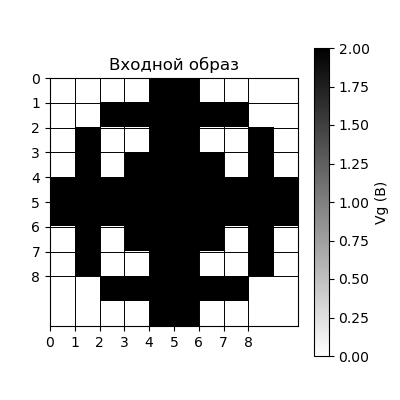

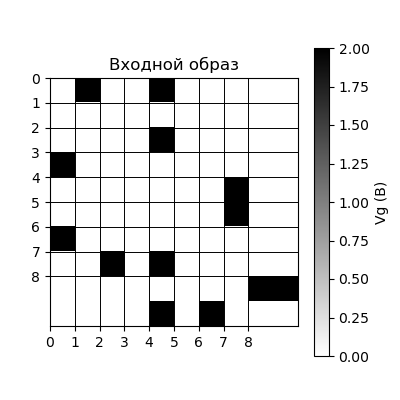

In [5]:
def show_input(Vg, ax=None):
    img = Vg.reshape(10, 10)

    # Если ось не передана, создаем новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    im = ax.imshow(
        img,
        cmap='gray_r',
        vmin=0,
        vmax=2,
        interpolation='nearest',
        extent=[0, 10, 10, 0]
    )

    # Границы пикселей
    ax.set_xticks(np.arange(0, 9, 1))
    ax.set_yticks(np.arange(0, 9, 1))
    ax.grid(True, color='black', linewidth=0.7)
    ax.set_title('Входной образ')

    # Цветовая шкала только если передан новый объект figure
    if ax.figure.stale:
        plt.colorbar(im, ax=ax, label='Vg (В)')

    # Отображение только если нет внешнего управляющего фигуры
    if ax.figure.stale:
        plt.show()


show_input(pattern_vector)
show_input(generate_Vg("noise"))

## Проверка реакции мемристоров на вход

In [6]:
class Memristor:
    """Модель мемристора для нейронной сети с фиксированными параметрами"""
    def __init__(self, params, x0=None):
        self.params = params.copy()
        self.x = x0 if x0 is not None else params[6]  # начальное состояние
    
    def R(self):
        """Текущее сопротивление мемристора"""
        Ron, Roff = self.params[0], self.params[1]
        return Ron * self.x + Roff * (1 - self.x)
    
    def I(self, V):
        """Ток через мемристор при напряжении V"""
        return V / self.R() if self.R() != 0 else 0
    
    def update_state(self, V, dt=1.0):
        """Обновление состояния x мемристора за шаг dt"""
        Ron, mu_v, Vp, Vn, D = self.params[0], self.params[2], self.params[3], self.params[4], self.params[5]
        I_mem = self.I(V)
        if V >= Vp:
            exponent = Ron * I_mem / Vp
            dx = (mu_v * Vp / (D*D)) * np.exp(np.clip(exponent, -100, 100)) * dt
        elif V <= Vn:
            exponent = Ron * I_mem / Vn
            dx = (mu_v * Vn / (D*D)) * np.exp(np.clip(exponent, -100, 100)) * dt
        else:
            dx = mu_v * Ron * I_mem / (D*D) * dt
        self.x = np.clip(self.x + dx, 0, 1)


In [7]:
params = np.array([
    35.3541,    # Ron
    2060.28,    # Roff
    2910.03,    # mu_v
    0.174543,   # Vp
    -2.19477,   # Vn
    529.95,     # D
    0.88529    # x0
])


memristors = [
    Memristor(params, x0=np.random.rand())
    for _ in range(100)
]

In [8]:
def compute_I_sum(Vg, memristors):
    I = 0.0
    for i in range(100):
        if Vg[i] > 0:          # транзистор открыт
            I += Vg[i] / memristors[i].R()
    return I


In [9]:
Vg = generate_Vg("pattern")
I = compute_I_sum(Vg, memristors)
print("I_sum =", I)

I_sum = 0.2858228096384784


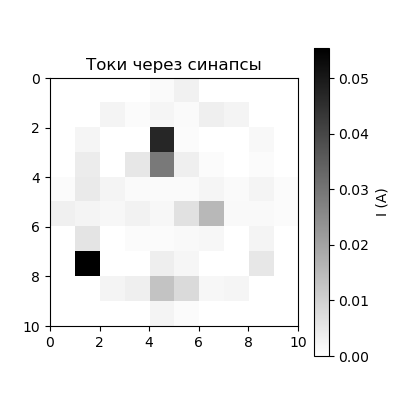

In [10]:
def show_currents(Vg, memristors):
    I = np.zeros(100)
    for i in range(100):
        if Vg[i] > 0:
            I[i] = Vg[i] / memristors[i].R()

    fig, ax = plt.subplots(figsize=(4,4))

    im = ax.imshow(
        I.reshape(10, 10),
        cmap='gray_r',
        interpolation='nearest',
        extent=[0,10,10,0]
    )

    fig.colorbar(im, ax=ax, label='I (A)')
    ax.set_title('Токи через синапсы')

    plt.show()


show_currents(generate_Vg("pattern"), memristors)


## Обучение нейрона

In [11]:
# нейрон
R_int = 1e3        # 1 кОм
C_int = 45e-6      # 45 мкФ
V_th = 3e-3        # 3 мВ

# обратная связь
Vte_pos = 1.5      # +1.5 В
Vte_neg = -1.6     # -1.6 В
Vte_0 = 0.01       # 10 мВ

tau_r = 20e-3      # 20 мс
tau_s = 2e-3       # 2 мс
tau_out = 10e-3    # 10 мс

dt = 1e-4          # 0.1 мс


In [12]:
memristors = [Memristor(params) for _ in range(100)]

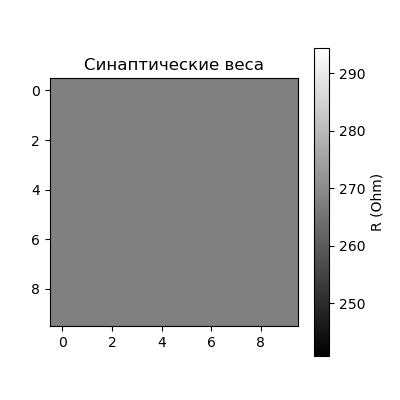

In [13]:
def show_weights(memristors):
    R_vals = np.array([m.R() for m in memristors])
    img = R_vals.reshape(10, 10)
    
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    plt.colorbar(label='R (Ohm)')
    plt.title("Синаптические веса")
    plt.grid(False)
    plt.show()

show_weights(memristors)

In [14]:
def V_te(tau):
    if tau <= tau_s:
        return Vte_pos
    elif tau_s < tau <= tau_r/2:
        return Vte_0
    elif tau_r/2 < tau <= tau_r/2 + tau_s:
        return Vte_neg
    elif tau_r/2 + tau_s < tau <= tau_r:
        return Vte_0
    else:
        return 0.0


In [15]:
def neuron_step(V_int, Vg, memristors, tau):
    I_sum = 0.0
    
    for i, mem in enumerate(memristors):
        V_mem = Vg[i] - V_int
        I_sum += mem.I(V_mem)
    
    # интеграция
    dV = (I_sum - V_int / R_int) / C_int
    V_int_new = V_int + dV * dt
    
    fired = False
    if V_int_new >= V_th:
        V_int_new = 0.0
        tau = 0.0
        fired = True
    
    # если нейрон активен — обучение
    if tau < tau_r:
        Vte = V_te(tau)
        for i, mem in enumerate(memristors):
            if Vg[i] > 0:  # активный вход
                mem.update_state(Vte, dt)
    
    tau += dt
    return V_int_new, tau, fired


In [16]:
def run_epoch_training(mode, memristors):
    T = 0.01
    steps = int(T / dt)
    
    Vg = generate_Vg(mode)
    V_int = 0.0
    tau = tau_r + dt
    
    V_int_trace = []
    V_te_trace = []
    spikes = []
    
    for _ in range(steps):
        # значение Vte ДО шага
        V_te_trace.append(V_te(tau) if tau < tau_r else 0.0)
        
        V_int, tau, fired = neuron_step(V_int, Vg, memristors, tau)
        
        V_int_trace.append(V_int)
        spikes.append(fired)



In [17]:
weights_history = []
n_epochs = 1000

for epoch in range(n_epochs):
    mode = "pattern" if np.random.rand() < 0.5 else "noise"
    run_epoch_training(mode, memristors)
    
    weights_history.append([m.R() for m in memristors])


In [18]:
R_last = np.array(weights_history[-1])
print("R min:", R_last.min())
print("R max:", R_last.max())


R min: 187.15714787425003
R max: 261.1619275334007


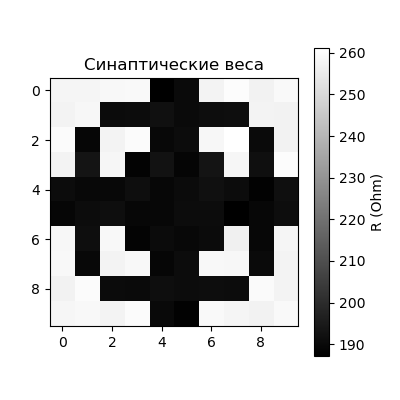

In [19]:
show_weights(memristors)

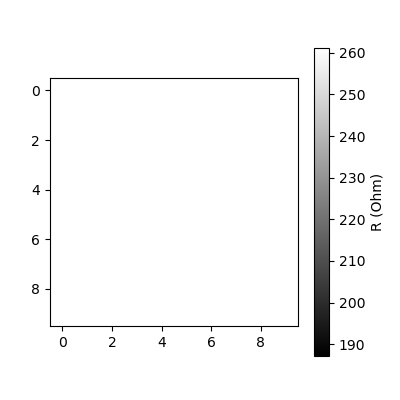

In [20]:
def animate_weights(weights_history, Rmin, Rmax):
    fig, ax = plt.subplots(figsize=(4,4))

    im = ax.imshow(
        np.array(weights_history[0]).reshape(10,10),
        cmap='gray',
        vmin=Rmin,
        vmax=Rmax
    )

    fig.colorbar(im, ax=ax, label='R (Ohm)')

    def update(frame):
        im.set_data(np.array(weights_history[frame]).reshape(10,10))
        ax.set_title(f"Эпоха {frame}")
        return [im]

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=len(weights_history),
        interval=200
    )
    return ani


ani = animate_weights(
    weights_history,
    Rmin=R_last.min(),
    Rmax=R_last.max()
)
plt.show()
